In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython import display
import sys
import random
import cv2
%matplotlib inline
import imutils


In [11]:
pip install opencv-python==3.4.2.16; pip install opencv-contrib-python==3.4.2.16

Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install imutils

  Stored in directory: /Users/xushusen/Library/Caches/pip/wheels/16/84/1f/bf88641293cda2c8be81a5c4b8ca973dd9125a6dc3767417fd
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


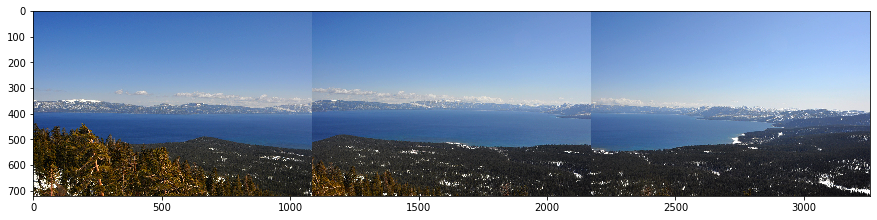

In [2]:
plt.rcParams['figure.figsize'] = [15, 15]

def load_image(filename):
    img = np.asarray(Image.open(filename))
    img = img.astype("float32")/255.
    return img

def show_image(img):
    plt.imshow(img, interpolation='nearest')
    
center_img = load_image("mountain_center.png")
left_img   = load_image("mountain_left.png")
right_img  = load_image("mountain_right.png")

show_image(np.concatenate([left_img, center_img, right_img], axis=1))

In [15]:
def compute_homography(src, dst):
    '''Computes the homography from src to dst.
    
    Input:
        src: source points, shape (n, 2)
        dst: destination points, shape (n, 2)
    Output:
        H: homography from source points to destination points, shape (3, 3)
        
    TODO: Implement the A matrix. 
    '''
    
    A = np.zeros([2*src.shape[0], 9])
    # Your code here.
    # temp array1: size: 2n * 3, every rows is [xi,yi,1]: points in src
    temp_array1 = np.ones([2*src.shape[0], 3])
    temp_array1[0:2*src.shape[0]:2, 0:2] = src[:,:]
    temp_array1[1:2*src.shape[0]:2, 0:2] = src[:,:]
    
    #print("temp_array1  ", temp_array1)
        
    # temp array2: size 2n*1, like [[-x0'],[-y0'],[-x1'],[-y'],......], these from dst 
    temp_array2 = np.zeros([2*dst.shape[0], 1])
    
    temp_array2[0:2*dst.shape[0]:2,:] = dst[:,0]
    temp_array2[1:2*dst.shape[0]:2,:] = dst[:,1]
    
    #print("temp_array2   ", temp_array2)
    
    # Combine
    A[0:A.shape[0]:2,0:2] = src
    A[1:A.shape[0]:2,3:5] = src
    
    A[0:A.shape[0]:2,2] = 1
    A[1:A.shape[0]:2,5] = 1
    
    A[:,6:9] = - temp_array2 * temp_array1
    
    
    w, v = np.linalg.eig(np.dot(A.T, A))
    index = np.argmin(w)
    H = v[:, index].reshape([3,3])
    return H
    

def apply_homography(src, H):
    '''Applies a homography H onto the source points.
    
    Input:
        src: source points, shape (n, 2)
        H: homography from source points to destination points, shape (3, 3)
    Output:
        dst: destination points, shape (n, 2)
    
    TODO: Implement the apply_homography function
    '''
    #implement this using homogenous coordinates.
    src_h = np.ones([src.shape[0], 3])
    src_h[:,0:2] = src
    
    # return value dst
    dst = np.zeros([src.shape[0],2])
    dst_h_t = np.dot(H, np.transpose(src_h))
    dst_h = np.transpose(dst_h_t)
    dst[:,0] = dst_h[:,0] / dst_h[:,2]
    dst[:,1] = dst_h[:,1] / dst_h[:,2]
    
    return dst

In [3]:
def backward_warp_img(src_img, H, dst_img_size):
    '''Backward warping of the source image using a homography.
    
    Input:
        src_img: source image, shape (m, n, 3)
        H: homography from destination to source image, shape (3, 3)
        dst_img_size: height and width of destination image, shape (2,)
    Output:
        dst_img: destination image, shape (m, n, 3)
    
    TODO: Implement the backward_warp_img function. 
    '''
    num_row = 0
    num_column = 0
    
    # dst_y
    
    # newest
    dst_img = np.zeros([dst_img_size[0], dst_img_size[1],3])
    for num_row in range(dst_img_size[0]):
        for num_column in range(dst_img_size[1]):
            temp_d = np.array([[num_column],[num_row],[1]])
            temp_s = np.dot(H,temp_d)
            temp_s[0][0] = (temp_s[0][0] / temp_s[2][0])
            temp_s[1][0] = (temp_s[1][0] / temp_s[2][0])
            x = int(temp_s[0][0])
            y = int(temp_s[1][0])
           
            #print("num_column: ",num_column,"   x:  ",x)
            #print("num_row:  ",num_row,"   y:  ",y)
            #print("w:  ",temp_s[0][0])
            if x >= 0 and x < src_img.shape[1]:
                if y >= 0 and y < src_img.shape[0]:
                    dst_img[num_row][num_column] = src_img[y][x]
            
    return dst_img
    

def binary_mask(img):
    '''Create a binary mask of the image content.
    
    Input:
        img: source image, shape (m, n, 3)
    Output:
        mask: image of shape (m, n) and type 'int'. For pixel [i, j] of mask, if img[i, j] > 0 
              in any of its channels, mask[i, j] = 1. Else, (if img[i, j] = 0), mask[i, j] = 0.
    '''
    
    mask = (img[:, :, 0] > 0) | (img[:, :, 1] > 0) | (img[:, :, 2] > 0)
    mask = mask.astype("int")
    
    return mask

In [ ]:
def test_warp():
    src_img = load_image('portrait_small.png')
    canvas = load_image('Osaka.png')

    src_pts = np.matrix('1, 1; 1, 400; 326, 1; 326, 400')
    canvas_pts = np.matrix('100, 18; 84, 437; 276, 71; 286, 424')
    H = compute_homography(src_pts, canvas_pts)

    dst_img = backward_warp_img(src_img, np.linalg.inv(H), [canvas.shape[0], canvas.shape[1]])
    dst_mask = 1 - binary_mask(dst_img)
    dst_mask = np.stack((dst_mask,) * 3, -1)
    out_img = np.multiply(canvas, dst_mask) + dst_img

    warp_img = np.concatenate((canvas, out_img), axis=1)

    show_image(np.clip(warp_img, 0, 1))
    
test_warp()

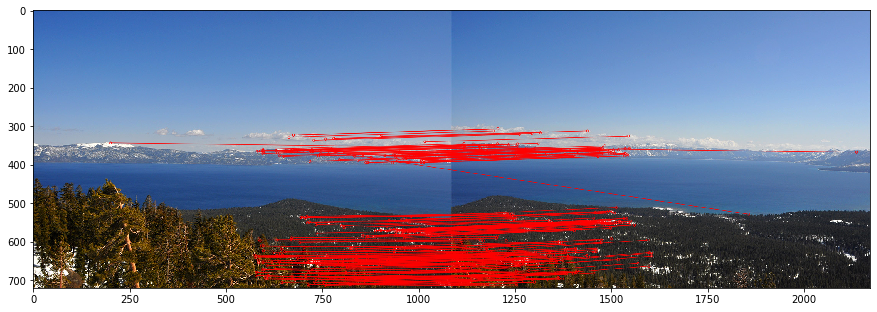

In [4]:
def genSIFTMatchPairs(img1, img2):
    sift = cv2.xfeatures2d.SIFT_create()
    #img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    #img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key = lambda x:x.distance)
    
    pts1 = np.zeros((250,2))
    pts2 = np.zeros((250,2))
    for i in range(250):
        pts1[i,:] = kp1[matches[i].queryIdx].pt
        pts2[i,:] = kp2[matches[i].trainIdx].pt
    
    return pts1, pts2, matches[:250], kp1, kp2

def test_matches():
    img1 = cv2.imread('mountain_left.png')
    img2 = cv2.imread('mountain_center.png')

    pts1, pts2, matches, kp1, kp2 = genSIFTMatchPairs(img1, img2)

    matching_result = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=2, matchColor=(0,0,255))
    plt.imshow(cv2.cvtColor(matching_result, cv2.COLOR_BGR2RGB))

test_matches()

In [5]:
import math
def RANSAC(Xs, Xd, max_iter, eps):
    '''Finds correspondences between two sets of points using the RANSAC algorithm.
    
    Input:
        Xs: the first set of points (source), shape [n, 2]
        Xd: the second set of points (destination) matched to the first set, shape [n, 2]
        max_iter: max iteration number of RANSAC
        eps: tolerance of RANSAC
    Output:
        inliers_id: the indices of matched pairs when using the homography given by RANSAC
        H: the homography, shape [3, 3]
    
    TODO: Implement the RANSAC function. 
    '''
    # ed
    num_match = Xs.shape[0]
    # the count number of iteration
    i = 0
    # the count of number of indices of 
    j = 0
    inliers_id = []
    
    for i in range(0,max_iter):
        # randomly select 4 matched points
        sample_set = random.sample(range(0, num_match), 4)
        src_sample = np.matrix(Xs[sample_set])
        dst_sample = np.matrix(Xd[sample_set])
        H_sample = compute_homography(src_sample, dst_sample)
        
        temp_inliers_id = []
        match_pts = apply_homography(Xs, H_sample)
        # caculate the euclidean distances between transformed destination points and given destination points
        temp = np.sum(pow((match_pts - Xd),2), axis=1)
        euc_dst =  np.sqrt(temp)
        
        j = 0
        for j in range(Xd.shape[0]):
            if euc_dst[j] < eps:
                temp_inliers_id.append(j)
        
        if len(temp_inliers_id) > len(inliers_id):
            inliers_id = temp_inliers_id
            H = H_sample
    return inliers_id, H    

In [ ]:
def test_ransac():
    img1 = cv2.imread('mountain_left.png')
    img2 = cv2.imread('mountain_center.png')

    pts1, pts2, matches, kp1, kp2 = genSIFTMatchPairs(img1, img2)
    
    inliers_idx, H = RANSAC(pts1, pts2, 500, 20)

    new_matches = []
    for i in range(len(inliers_idx)):
        new_matches.append(matches[inliers_idx[i]])

    matching_result = cv2.drawMatches(img1, kp1, img2, kp2, new_matches, None, flags=2, matchColor=(0,0,255))
    plt.imshow(cv2.cvtColor(matching_result, cv2.COLOR_BGR2RGB))
    
test_ransac()


In [13]:
def stitch_img():
    '''Stitch a list of images together.
    
    Input: 
        imgs: a list of images.
    Output:
        stitched_img: a single stiched image.
        
    TODO: implement the stitch_img function. 
    '''
    img1 = cv2.imread('mountain_left.png')
    img2 = cv2.imread('mountain_center.png')

    pts1, pts2, matches, kp1, kp2 = genSIFTMatchPairs(img1, img2)
    
    inliers_idx, H = RANSAC(pts1, pts2, 500, 20)

    new_matches = []
    for i in range(len(inliers_idx)):
        new_matches.append(matches[inliers_idx[i]])

    matching_result = cv2.drawMatches(img1, kp1, img2, kp2, new_matches, None, flags=2, matchColor=(0,0,255))
    plt.imshow(cv2.cvtColor(matching_result, cv2.COLOR_BGR2RGB))
    
    
    

In [14]:
stitch_img()

NameError: name 'compute_homography' is not defined

In [9]:
'''
def stitch_img(imgs):
    
    center_img = imgs[0]
    left_img = imgs[1]
    right_img = imgs[2]
    
    # take the center_img as reference img
    
    # warp the mountain_left
    pts1, pts2, matches, kp1, kp2 = genSIFTMatchPairs(center_img, left_img)
    
    inliers_idx, H = RANSAC(pts1, pts2, 500, 20)
    
    dst_left_img = backward_warp_img(center_img, np.linalg.inv(H), [left_img.shape[0], left_img.shape[1]])
    
    
    # 
    
    
    
    
    return stitch_imgs
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    dst_left_mask = 1 - binary_mask(dst_left_img)
    dst_left_mask = np.stack((dst_left_mask,) * 3, -1)
    out_left_img = np.multiply(left_img, dst_left_mask) + dst_left_img
    
    #out_left_img = out_left_img.astype("float32")
    
    #out_left_img = dst_left_img 
    # warp the mountain_right
    pts1_r, pts2_r, matches_r, kp1_r, kp2_r = genSIFTMatchPairs(center_img, right_img)
    
    inliers_idx_r, H_r = RANSAC(pts1_r, pts2_r, 500, 20)
    
    dst_right_img = backward_warp_img(center_img, np.linalg.inv(H_r), [right_img.shape[0], right_img.shape[1]])

    dst_right_mask = 1 - binary_mask(dst_right_img)
    dst_right_mask = np.stack((dst_right_mask,) * 3, -1)
    out_right_img = np.multiply(right_img, dst_right_mask) + dst_right_img
    
    #out_right_img = dst_right_img
    
    #stitch_imgs = np.concatenate([out_left_img, center_img, out_right_img], axis=1)
    '''
    #return stitch_imgs

'\ndef stitch_img(imgs):\n    \n    center_img = imgs[0]\n    left_img = imgs[1]\n    right_img = imgs[2]\n    \n    # take the center_img as reference img\n    \n    # warp the mountain_left\n    pts1, pts2, matches, kp1, kp2 = genSIFTMatchPairs(center_img, left_img)\n    \n    inliers_idx, H = RANSAC(pts1, pts2, 500, 20)\n    \n    dst_left_img = backward_warp_img(center_img, np.linalg.inv(H), [left_img.shape[0], left_img.shape[1]])\n    \n    \n    # \n    \n    \n    \n    \n    return stitch_imgs\n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    \n    dst_left_mask = 1 - binary_mask(dst_left_img)\n    dst_left_mask = np.stack((dst_left_mask,) * 3, -1)\n    out_left_img = np.multiply(left_img, dst_left_mask) + dst_left_img\n    \n    #out_left_img = out_left_img.astype("float32")\n    \n    #out_left_img = dst_left_img \n    # warp the mountain_right\n    pts1_r, pts2_r, matches_r, kp1_r, k

In [10]:
center_img = cv2.imread("mountain_center.png")
left_img = cv2.imread("mountain_left.png")
right_img = cv2.imread("mountain_right.png")
#final_img = stitch_img([center_img, left_img, right_img])
final_img = stitch_img([center_img, left_img])


plt.imshow(cv2.cvtColor(final_img.astype("uint8"), cv2.COLOR_BGR2RGB));

NameError: name 'stitch_img' is not defined